In [1]:
import sys
import os

In [2]:
curr_dir = sys.path[0]

src_dir = os.path.abspath(os.path.join(curr_dir, os.pardir))
main_dir = os.path.abspath(os.path.join(src_dir, os.pardir))
notebooks_dir = os.path.join(main_dir, 'notebooks')

In [3]:
curr_dir

'/home/baambriz/q2_code/src/analysis'

In [49]:
import numpy as np
import pandas as pd
import torch
import torch_geometric
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
from tqdm.notebook import tqdm
import numpy as np
local = False
from GraphDataset import GraphDataset

# loading q1 results

### Fully Connected NN

In [7]:
fcnn_predictions = pd.read_csv(main_dir + '/fcnn_predictions.csv', index_col = False)

In [8]:
fcnn_predictions.shape

(4679, 4)

In [9]:
fcnn_predictions.head()

,hbb_prediction,qcd_prediction,hbb_label,qcd_label
0,0.218978,0.781022,0.0,1.0
1,0.642642,0.357358,0.0,1.0
2,0.960215,0.039785,1.0,0.0
3,0.868078,0.131922,1.0,0.0
4,0.999365,0.000635,1.0,0.0


### Deep Sets NN

In [11]:
dsnn_predictions = pd.read_csv(main_dir + '/dsnn_predictions.csv', index_col=False)

In [12]:
dsnn_predictions.shape

(4679, 4)

In [13]:
dsnn_predictions.head()

,hbb_prediction,qcd_prediction,hbb_label,qcd_label
0,0.521757,0.478243,0.0,1.0
1,0.747701,0.252299,0.0,1.0
2,0.885157,0.114843,1.0,0.0
3,0.825939,0.174061,1.0,0.0
4,0.955771,0.044229,1.0,0.0


# loading q2 results

### Graph NN 

In [33]:
graph_predictions = pd.read_csv(main_dir + '/GENConv_predictions.csv', index_col=False)

In [34]:
graph_predictions.shape

(1889, 2)

In [35]:
import torch

graph_predictions['QCD_label'] = graph_predictions['hbb_label'].apply(lambda x: 1 if (x == 0) else 0)

graph_predictions['hbb_sig'] = torch.nn.Sigmoid()(torch.tensor(graph_predictions['hbb_prediction']))

graph_predictions['qcd_sig'] = 1 - graph_predictions['hbb_sig']

## Evaluation / Comparison

### Graph of AUC

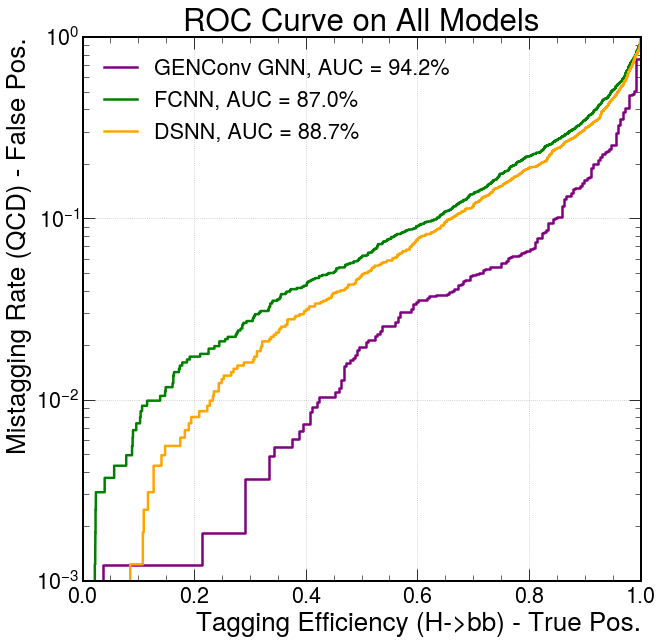

In [112]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.ROOT)
# create ROC curves
fpr_gnn, tpr_gnn, threshold_gnn = roc_curve(graph_predictions['hbb_label'], graph_predictions['hbb_sig'])
fpr_fcnn, tpr_fcnn, threshold_fcnn = roc_curve(fcnn_predictions['hbb_label'], fcnn_predictions['hbb_prediction'] )
fpr_dsnn, tpr_dsnn, threshold_dsnn = roc_curve(dsnn_predictions['hbb_label'], dsnn_predictions['hbb_prediction'])
# plot ROC curves
plt.figure()
plt.plot(tpr_gnn, fpr_gnn, lw=2.5, label="GENConv GNN, AUC = {:.1f}%".format(auc(fpr_gnn,tpr_gnn)*100), c = 'purple')
plt.plot(tpr_fcnn, fpr_fcnn, lw=2.5, label="FCNN, AUC = {:.1f}%".format(auc(fpr_fcnn,tpr_fcnn)*100), c = 'green')
plt.plot(tpr_dsnn, fpr_dsnn, lw=2.5, label="DSNN, AUC = {:.1f}%".format(auc(fpr_dsnn,tpr_dsnn)*100), c = 'orange')
plt.xlabel(r'Tagging Efficiency (H->bb) - True Pos.')
plt.ylabel(r'Mistagging Rate (QCD) - False Pos.')
plt.title('ROC Curve on All Models')
plt.semilogy()
plt.ylim(0.001, 1)
plt.xlim(0, 1)
plt.grid(True)
plt.legend(loc='upper left')
plt.show()

### Graph of ROC using DDT (Designed Decorrelated Taggers) Procedure

In [20]:
sys.path.insert(0, os.path.realpath('../../config'))

In [21]:
sys.path

['/home/baambriz/q2_code/config',
 '/home/baambriz/q2_code/src/analysis',
 '/opt/conda/lib/python39.zip',
 '/opt/conda/lib/python3.9',
 '/opt/conda/lib/python3.9/lib-dynload',
 '',
 '/home/baambriz/.local/lib/python3.9/site-packages',
 '/opt/conda/lib/python3.9/site-packages',
 '/opt/conda/lib/python3.9/site-packages/IPython/extensions',
 '/home/baambriz/.ipython']

In [22]:
from utils import find_nearest

def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx, array[idx]

In [75]:
import yaml

with open('../../config/definitions.yml') as file:
    # The FullLoader parameter handles the conversion from YAML
    # scalar values to Python the dictionary format
    definitions = yaml.load(file, Loader=yaml.FullLoader)
    
features = definitions['features']
spectators = definitions['spectators']
labels = definitions['labels']

nfeatures = definitions['nfeatures']
nspectators = definitions['nspectators']
nlabels = definitions['nlabels']
ntracks = definitions['ntracks']

from DataGenerator import DataGenerator
# load testing file
test_files = ['~/teams/DSC180A_FA21_A00/a11/test/ntuple_merged_0.root']
test_generator = DataGenerator(test_files, features, labels, spectators, batch_size=1024, n_dim=ntracks, 
                               remove_mass_pt_window=True, 
                               return_spectators=True,
                               remove_unlabeled=True, max_entry = 15000)

from tqdm.notebook import tqdm

#collecting truth labels
spec_array_test = []
label_array_test = []
for t in tqdm(test_generator, total=len(test_generator)):
    spec_array_test.append(t[1][1])
    label_array_test.append(t[1])
label_array_test = np.concatenate(np.column_stack(label_array_test), axis=1)
spec_array_test = np.concatenate(spec_array_test, axis=0)

  0%|          | 0/15 [00:00<?, ?it/s]

In [51]:
#loading truth-level data for GNN
from torch_geometric.data import Data, DataListLoader, Batch
from torch.utils.data import random_split
file_names_test = ['/teams/DSC180A_FA20_A00/b06particlephysics/test/ntuple_merged_0.root']
test_dataset = GraphDataset('gdata_test', features, labels, spectators, n_events=15000, n_events_merge=1, 
                             file_names=file_names_test)

def collate(items):
    l = sum(items, [])
    return Batch.from_data_list(l)

torch.manual_seed(0)
batch_size = 32

test_loader = DataListLoader(test_dataset, batch_size=batch_size, pin_memory=True, shuffle=False)
test_loader.collate_fn = collate

/opt/conda/lib/python3.9/site-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataListLoader' is deprecated, use 'loader.DataListLoader' instead
  warnings.warn(out)


In [97]:
test_samples = len(test_dataset)
t = tqdm(enumerate(test_loader),total=test_samples/batch_size)
label_array_test_gnn = []
spec_gnn = []
for i,data in t:
    data = data.to(device)
    spec_gnn.append(data.u)
    label_array_test_gnn.append(data.y.cpu().numpy())
label_array_test_gnn = np.concatenate(label_array_test_gnn)
spec_gnn = np.concatenate(spec_gnn, axis=0)

  0%|          | 0/59.03125 [00:00<?, ?it/s]

DDT Procedure

1. Bin the mass 10 bins / size 20 
2. Select the data from each bin
3. Per bin, find the threshold hbb-sig which corresponds closely to a 1% fpr
4. Per bin, find the sum or total # of true-labeled hbb events that achieve the threshold 
5. In #4 (divided by total number of signal events in all bins)


In [129]:
jet_masses = pd.Series(spec_gnn[:,0], copy=True).sort_values(ascending=True)

In [131]:
pd.qcut(jet_masses, q = 10)

1211    (-0.0010305, 2.887]
448     (-0.0010305, 2.887]
106     (-0.0010305, 2.887]
1710    (-0.0010305, 2.887]
1787    (-0.0010305, 2.887]
               ...         
490     (165.166, 1122.765]
6       (165.166, 1122.765]
1327    (165.166, 1122.765]
990     (165.166, 1122.765]
1181    (165.166, 1122.765]
Length: 1889, dtype: category
Categories (10, interval[float64]): [(-0.0010305, 2.887] < (2.887, 5.857] < (5.857, 11.173] < (11.173, 20.013] ... (61.257, 91.323] < (91.323, 115.755] < (115.755, 165.166] < (165.166, 1122.765]]

In [82]:
# plot curves
#plt.figure()
#plt.plot(tpr_gnn_ddt, fpr_gnn_ddt, color = 'purple', linestyle = '--', lw=2.5, label="GENConv GNN w/ DDT, AUC = {:.1f}%".format(auc(fpr_gnn_ddt, tpr_gnn_ddt)*100))
#plt.plot(tpr_fcnn_ddt, fpr_fcnn_ddt, color = 'green', linestyle = '--', lw=2.5, label="FCNN w/ DDT, AUC = {:.1f}%".format(auc(fpr_fcnn_ddt, tpr_fcnn_ddt)*100))
#plt.plot(tpr_dsnn_ddt, fpr_dsnn_ddt, color = 'orange', linestyle = '--', lw=2.5, label="DSNN w/ DDT, AUC = {:.1f}%".format(auc(fpr_dsnn_ddt, tpr_dsnn_ddt)*100))
#plt.xlabel(r'Tagging Efficiency (H-> bb)')
#plt.ylabel(r'Mistagging Rate (QCD)')
#plt.title('ROC Curve on All Models with DDT procedure')
#plt.semilogy()
#plt.ylim(0.001, 1)
#plt.xlim(0, 1)
#plt.grid(True)
#plt.legend(loc='upper left')
#plt.show()

In [83]:
fpr_gnn, tpr_gnn, threshold_gnn = roc_curve(graph_predictions['hbb_label'], graph_predictions['hbb_sig'])

In [84]:
graph_predictions

,hbb_prediction,hbb_label,QCD_label,hbb_sig,qcd_sig
0,-8.443853,0,1,2.151730e-04,0.999785
1,-14.679830,0,1,4.213380e-07,1.000000
2,-5.623161,0,1,3.600193e-03,0.996400
3,-7.973312,0,1,3.444173e-04,0.999656
4,-9.264545,0,1,9.471485e-05,0.999905
...,...,...,...,...,...
1884,-8.660225,0,1,1.733153e-04,0.999827
1885,-15.552607,0,1,1.760307e-07,1.000000
1886,-10.798943,0,1,2.042066e-05,0.999980
1887,-14.898463,0,1,3.385943e-07,1.000000


(40.0, 200.0)

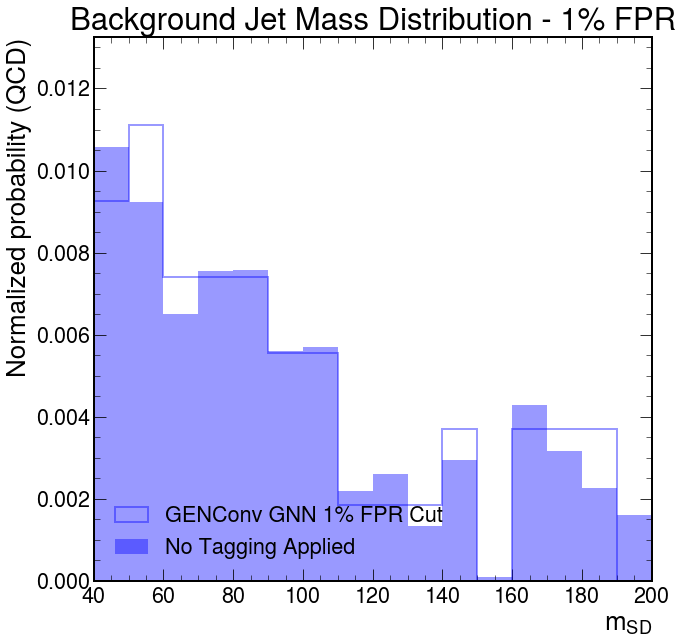

In [125]:
plt.figure()
for wp in [0.01]:
    idx_gnn, val_gnn = find_nearest(fpr_gnn, wp)
    plt.hist(spec_gnn[:,0], bins=np.linspace(20, 220, 21), 
             weights=label_array_test_gnn[:, 0]*(graph_predictions['hbb_sig'] > threshold_gnn[idx_gnn]),
             alpha=0.4, density=True, color = 'blue',label='GENConv GNN {}% FPR Cut'.format(int(wp*100)), histtype='step', linewidth = 2)
    #plt.hist(spec_array_test[:, 0], bins=np.linspace(20, 220, 21), 
    #         weights= label_array_test[:, 0] * (graph_predictions['qcd_sig'] > threshold_gnn[idx_gnn]),
    #         alpha=0.4, density=True, color = 'red',label='GENConv GNN w/ DDT, {}% FPR Cut'.format(int(wp*100)),histtype='step', linewidth = 2)
plt.hist(spec_gnn[:,0], bins=np.linspace(20, 220, 21), 
         weights=label_array_test_gnn[:,0]*(graph_predictions['hbb_sig']),
         alpha=0.4, density=True, color = 'blue', label='No Tagging Applied'.format(int(wp*100)))
plt.title("Background Jet Mass Distribution - 1% FPR")
plt.legend(loc='lower left')
plt.xlabel(r'$m_{SD}$')
plt.ylabel(r'Normalized probability (QCD)')
plt.xlim(40, 200)

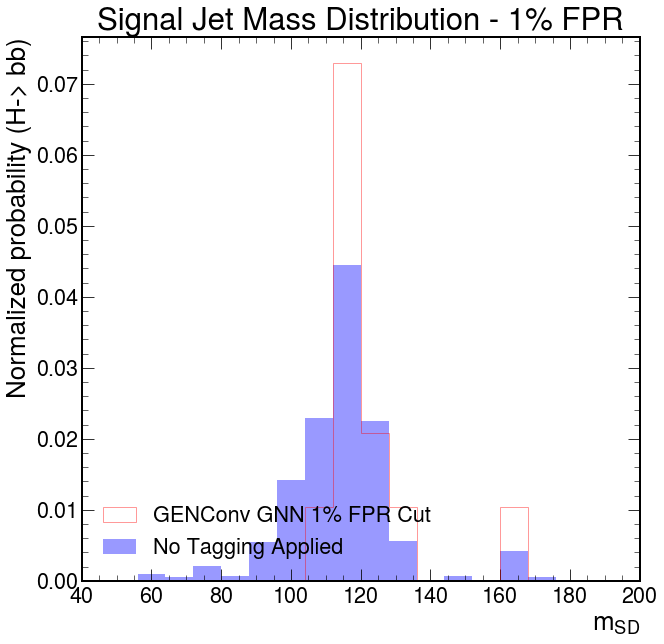

In [122]:
plt.figure()
for wp in [0.01]:
    idx_gnn, val_gnn = find_nearest(fpr_gnn, wp)
    plt.hist(spec_gnn[:,0], bins=np.linspace(40, 200, 21), 
             weights=label_array_test_gnn[:,1]*(graph_predictions['hbb_sig'] > threshold_gnn[idx_gnn]),
             alpha=0.4, density=True, color = 'red', label='GENConv GNN {}% FPR Cut'.format(int(wp*100)), histtype='step')
    #plt.hist(spec_array_test[:,0], bins=np.linspace(40, 200, 21), 
    #         weights=label_array_test[:,1] * (graph_predictions['hbb_sig'] > threshold_gnn[idx_gnn]),
    #         alpha=0.4, density=True, color='red', label='GENConv GNN DDT'.format(int(wp*100)),histtype='step')
plt.hist(spec_gnn[:,0], bins=np.linspace(40, 200, 21), 
         weights=label_array_test_gnn[:,1]*(graph_predictions['hbb_sig']),
         alpha=0.4, density=True, color = 'blue', label='No Tagging Applied'.format(int(wp*100)))
plt.title("Signal Jet Mass Distribution - 1% FPR")
plt.legend(loc='lower left')
plt.xlabel(r'$m_{SD}$')
plt.ylabel(r'Normalized probability (H-> bb)')
plt.xlim(40, 200)
plt.show()